# Optimizing EKG Circuit

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
ohm = UNITS.ohm
farad = UNITS.farad
volt = UNITS.volt
Hz = UNITS.Hz
second = UNITS.second;

In [3]:
params_amp_1 = Params(
    R = 2e3,   # ohm
    A = 5,      # volt
    f = 30,   # Hz
    vref = 2.5   #volt
)

,values
R,2000.0
A,5.0
f,30.0
vref,2.5


In [4]:
def make_system_amp(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    init = State(V_out = 0)
    t_end = 4 / f
    ts = linspace(0, t_end, 401)
    
    return System(R=R, A=A, f=f,
                  init=init, t_end=t_end, ts=ts,
                  vref=vref)

In [5]:
amp1 = make_system_amp(params_amp_1)

,values
R,2000
A,5
f,30
init,V_out 0 dtype: int64
t_end,0.133333
ts,"[0.0, 0.0003333333333333333, 0.000666666666666..."
vref,2.5


In [39]:
def amp(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    unpack(system)
    
    vin = A * np.cos(2 * pi * f * t)
    
    G = 1 + (100e3 / R)
    
    #vout = vref + (G * (vin))
    
    vout = vin * G
    
    return vout

In [40]:
results_amp_1 = amp(params_amp_1, amp1.ts, amp1);

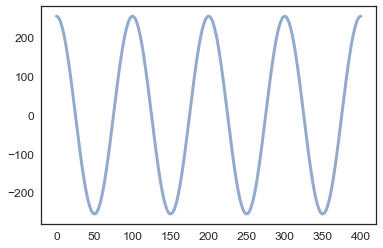

In [53]:
amp1_res = TimeSeries()
for i in range(401):
    amp1_res[i] = results_amp_1[i]
plot(amp1_res)

In [54]:
inter = interpolate(amp1_res)

In [41]:
amp1_vout = pd.DataFrame({'time':amp1.ts,
                          'vout':results_amp_1})
amp1_vout.set_index('time');

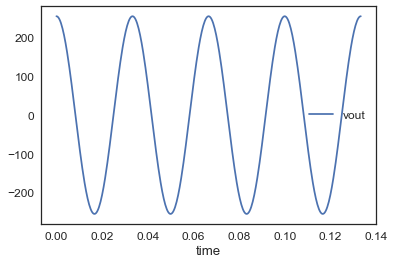

In [42]:
amp1_vout.plot('time','vout')

In [61]:
params1 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    A = 5,      # volt
    f = 10,   # Hz
    #vin = results_amp_1
    vin = results_amp_1
)

,values
R,4900
C,1e-06
A,5
f,10
vin,"[255.0, 254.49681574920925, 252.98924883519186..."


In [62]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    init = State(V_out = 0)
    omega = 2 * np.pi * f
    tau = R * C
    cutoff = 1 / R / C / 2 / np.pi
    t_end = 4 / f
    ts = linspace(0, t_end, 401)
    
    return System(R=R, C=C, A=A, f=f,
                  init=init, t_end=t_end, ts=ts,
                  omega=omega, tau=tau, cutoff=cutoff, vin=vin)

In [63]:
system1 = make_system(params1)

,values
R,4900
C,1e-06
A,5
f,10
init,V_out 0 dtype: int64
t_end,0.4
ts,"[0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006..."
omega,62.8319
tau,0.0049
cutoff,32.4806


In [64]:
def slope_func_init(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)"""

    vout = state
    
    unpack(system)
    
    vin = A * np.cos(2 * pi * f * t)
    
    dvoutdt = (vin - vout) / (R * C)
    
    return dvoutdt

In [65]:
results1, details1 = run_ode_solver(system1, slope_func_init, t_eval=system1.ts)

In [66]:
def plot_results(results):
    xs = results.V_out.index
    ys = results.V_out.values

    t_end = get_last_label(results)
    if t_end < 10:
        xs *= 1000
        xlabel = 'Time (ms)'
    else:
        xlabel = 'Time (s)'
        
    plot(xs, ys)
    decorate(xlabel=xlabel,
             ylabel='$V_{out}$ (volt)',
             legend=False)

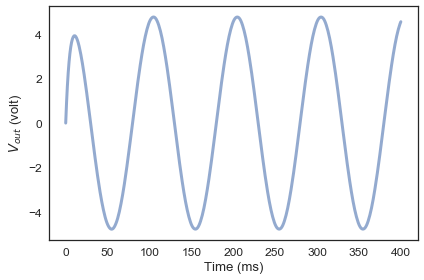

In [67]:
plot_results(results1)

In [68]:
params2 = Params(
    R = 100e3,   # ohm
    C = 1e-6,  # farad
    vin = results1.V_out
)

,values
R,100000
C,1e-06
vin,0.000 0.000000 0.001 0.922383 0.002 1...


In [69]:
system2 = make_system(params2)

,values
R,100000
C,1e-06
A,5
f,10
init,V_out 0 dtype: int64
t_end,0.4
ts,"[0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006..."
omega,62.8319
tau,0.1
cutoff,1.59155


In [70]:
def slope_func_high_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    #unpack(system)
    
    vin = interpolate(system.vin)
    
    dvoutdt = ((vin(t) - vout) * (system.R * system.C * system.omega)) / (system.R * system.C)
    
    return dvoutdt

In [71]:
def slope_func_low_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    #unpack(system)
    
    vin = interpolate(system.vin)
    
    dvoutdt = (vin(t) - vout) / (system.R * system.C)
    
    return dvoutdt

In [72]:
results2, details2 = run_ode_solver(system2, slope_func_high_pass, t_eval=system2.ts)

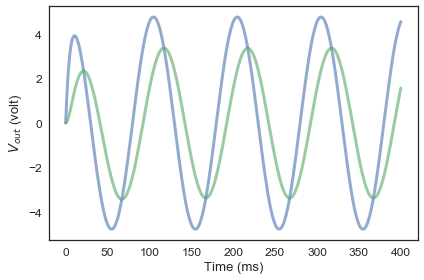

In [73]:
plot_results(results1)
plot_results(results2)

In [74]:
params3 = Params(
    R = 499,   # ohm
    C = 10e-6,  # farad
    vin = results2.V_out
)

,values
R,499
C,1e-05
vin,0.000 0.000000 0.001 0.028323 0.002 0...


In [75]:
system3 = make_system(params3)

,values
R,499
C,1e-05
A,5
f,10
init,V_out 0 dtype: int64
t_end,0.4
ts,"[0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006..."
omega,62.8319
tau,0.00499
cutoff,31.8948


In [76]:
results3, details3 = run_ode_solver(system3, slope_func_low_pass, t_eval=system3.ts)

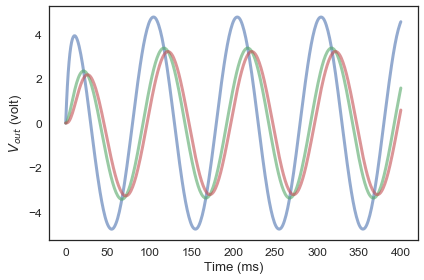

In [77]:
plot_results(results1)
plot_results(results2)
plot_results(results3)

In [78]:
params4 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    vin = results3.V_out
)

,values
R,4900
C,1e-06
vin,0.000 0.000000 0.001 0.002759 0.002 0...


In [79]:
system4 = make_system(params4)

,values
R,4900
C,1e-06
A,5
f,10
init,V_out 0 dtype: int64
t_end,0.4
ts,"[0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006..."
omega,62.8319
tau,0.0049
cutoff,32.4806


In [80]:
results4, details4 = run_ode_solver(system4, slope_func_low_pass, t_eval=system4.ts)

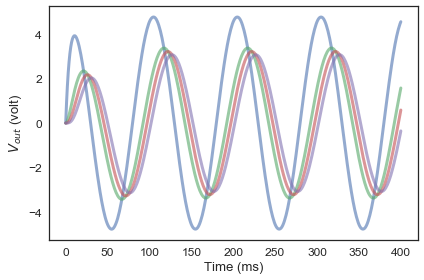

In [81]:
plot_results(results1)
plot_results(results2)
plot_results(results3)
plot_results(results4)